# Set libraries and import data

In [2]:
# Set the graphs as fixed.
%matplotlib inline
# Import necessary libraries for initial analysis
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# Read Data from CSV
sky_train = pd.read_csv("../data/sky_train.csv", index_col = 0)
sky_test = pd.read_csv("../data/sky_test.csv", index_col = 0)

In [4]:
# Reproduce the function from the EDA
def clean_ci_redshift(df):
    df_copy = df.copy()
    df_copy['color_index_u_g'] = df_copy['u'] - df_copy['g']
    df_copy['color_index_g_r'] = df_copy['g'] - df_copy['r']
    df_copy['color_index_r_i'] = df_copy['r'] - df_copy['i']
    df_copy['color_index_i_z'] = df_copy['i'] - df_copy['z']
    df_copy['redshift_log'] = np.log((df_copy['redshift']+0.006)/0.006)
    df_copy = df_copy.drop(['u','g','r','i','z','redshift'], axis = 1)
    return df_copy

We will use this transformation for now to preprocess the training data.

# Data preprocessing

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# custom function to pipeline Transformer
ci_redshift = FunctionTransformer(clean_ci_redshift)

# construction of preprocessing pipeline
preprocessing = Pipeline([('ci_redshift', ci_redshift), ('scaling', StandardScaler())])


In [6]:
# Final preprocessing of the Train Set
X = preprocessing.fit_transform(sky_train.drop('class', axis=1))
y = sky_train['class']

# Initial exploration models

In [7]:
# Import necessary features
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# simple models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# ensemble models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
# initialize all models
logistic_regression = LogisticRegression()
stoc_grad_desc = SGDClassifier()
k_near_neigh = KNeighborsClassifier()
naive_bayes = GaussianNB()
decision_tree = DecisionTreeClassifier()
ada_boost = AdaBoostClassifier()
bagging = BaggingClassifier()
extra_trees = ExtraTreesClassifier()
gradient_boost = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

models = [logistic_regression,stoc_grad_desc, k_near_neigh, naive_bayes,
          decision_tree, ada_boost, bagging, extra_trees, gradient_boost, random_forest]
names_models = ['Logistic Regression', 'Stochastic Gradient Descent', 'K-Nearest Neighbors', 
                'Naive-Bayes', 'Decision Tree', 'ADA Boost', 'Bagging Classifier', 'Extra Trees', 'Gradient Boost', 
                'Random Forest']

In [37]:
# create an empty dataframe
all_models_results = pd.DataFrame(columns = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 
                                             'test_f1_macro', 'test_roc_auc_ovo', 'model', 'time_to_train_sec'])

# loop that cross_validates all above models for several metrics
for name, model in zip(names_models, models):
    start = time.time()
    if name in ['Stochastic Gradient Descent']:
         results = cross_validate(model, X, y, scoring = ('accuracy', 'precision_macro', 
                                                     'recall_macro', 'f1_macro')) # SGD computes an error when calculating its AUC
    else:
        results = cross_validate(model, X, y, scoring = ('accuracy', 'precision_macro', 
                                                     'recall_macro', 'f1_macro', 'roc_auc_ovo'))
    for key in ['fit_time','score_time']:
        del results[key]
    for key in results.keys():
        results[key] = results[key].mean()
    results_model = pd.DataFrame(results, index = range(1))
    results_model['model'] = name
    all_models_results = pd.concat([all_models_results, results_model], ignore_index=True)
    elapsed_time = time.time()-start
    
    print("Finished iterating {} in: {} seconds".format(name,str(int(elapsed_time))))

Finished iterating Logistic Regression in: 64 seconds
Finished iterating Stochastic Gradient Descent in: 19 seconds
Finished iterating K-Nearest Neighbors in: 89 seconds
Finished iterating Naive-Bayes in: 15 seconds
Finished iterating Decision Tree in: 46 seconds
Finished iterating ADA Boost in: 303 seconds
Finished iterating Bagging Classifier in: 194 seconds
Finished iterating Extra Trees in: 215 seconds
Finished iterating Gradient Boost in: 1570 seconds
Finished iterating Random Forest in: 800 seconds


In [74]:
# Sort dataframe, reorder columns, add seconds to train and save to CSV
all_models_results = all_models_results.sort_values('test_accuracy', ascending=False)
all_models_results = all_models_results[['model', 'test_accuracy', 'test_precision_macro', 'test_recall_macro',
       'test_f1_macro', 'test_roc_auc_ovo']]
all_models_results = all_models_results.reset_index(drop=True)
all_models_results['time_to_train_sec'] = [800,194,1570,215,46,89,64,15,19,303]
all_models_results.to_csv('../data/initial_model_accuracy.csv')

In [75]:
all_models_results

,model,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc_ovo,time_to_train_sec
0,Random Forest,0.994233,0.992957,0.987411,0.990144,0.998152,800
1,Bagging Classifier,0.993820,0.992495,0.986508,0.989455,0.995773,194
2,Gradient Boost,0.993226,0.991415,0.985560,0.988444,0.998727,1570
3,Extra Trees,0.992800,0.991925,0.986372,0.989101,0.998296,215
4,Decision Tree,0.990441,0.983366,0.984097,0.983730,0.988073,46
5,K-Nearest Neighbors,0.990157,0.988613,0.984438,0.986489,0.993772,89
6,Logistic Regression,0.987420,0.985430,0.977905,0.981564,0.995633,64
7,Naive-Bayes,0.983788,0.977990,0.971538,0.974685,0.993138,15
8,Stochastic Gradient Descent,0.972051,0.971946,0.960175,0.965880,NaN,19
9,ADA Boost,0.885648,0.797394,0.663284,0.637844,0.904660,303


## Bagging Classification

In [10]:
#specify the parameters to be tested
n_est = [10,20,50,100]
max_features_opt = [0.93, 0.95, 0.97]
param_grid = dict(n_estimators = n_est, max_features=max_features_opt)

#perform the GridSearchCV
start = time.time()
bag_grid = GridSearchCV(bagging, param_grid, cv = 5, scoring='f1_macro', n_jobs=-1).fit(X, y)
elapsed_time = time.time()-start
print("Finished iterating in: {} seconds".format(str(int(elapsed_time))))
print(bag_grid.best_score_, bag_grid.best_params_)

Finished iterating in: 4109 seconds
0.989878755499328 {'max_features': 0.95, 'n_estimators': 100}


## Random Forest

In [9]:
#specify the parameters to be tested
n_est = [10, 50, 100, 200]
max_depth_opt = [5, 10, 25, 50]
param_grid = dict(n_estimators = n_est, max_depth=max_depth_opt)


#perform the GridSearchCV
start = time.time()
rd_grid = GridSearchCV(random_forest, param_grid, cv = 5, scoring='f1_macro', n_jobs=-1).fit(X, y)
elapsed_time = time.time()-start
print("Finished iterating in: {} seconds".format(str(int(elapsed_time))))
print(rd_grid.best_score_, rd_grid.best_params_)

Finished iterating in: 3134 seconds
0.9900964588772911 {'max_depth': 25, 'n_estimators': 100}


## K-Near Neighbors

In [8]:
#specify the parameters to be tested
n_neighbors=[5, 10, 50, 100]
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors = n_neighbors, weights=weights)


#perform the GridSearchCV
start = time.time()
k_grid = GridSearchCV(k_near_neigh, param_grid, cv = 5, scoring='f1_macro', n_jobs=-1).fit(X, y)
elapsed_time = time.time()-start
print("Finished iterating in: {} seconds".format(str(int(elapsed_time))))
print(k_grid.best_score_, k_grid.best_params_)

Finished iterating in: 362 seconds
0.9858467828525367 {'n_neighbors': 5, 'weights': 'distance'}


# Random Forest with Test Set

In [9]:
# final train with all train set for the Random forest Estimator
start = time.time()
rd_forest = RandomForestClassifier(n_estimators = 100, max_depth = 25).fit(X,y)
elapsed_time = time.time()-start
print("Finished training in: {} seconds".format(str(int(elapsed_time))))

Finished training in: 389 seconds


In [ ]:
# Final preprocessing of the Test Set
X_test = preprocessing.transform(sky_test.drop('class', axis=1))
y_test = sky_test['class']

In [ ]:

# Import necessary metrics and functions to better know the test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

[[9.99716312e-01 2.83687943e-04 0.00000000e+00]
 [1.47846978e-03 9.95749399e-01 2.77213084e-03]
 [0.00000000e+00 2.72556391e-02 9.72744361e-01]]
              precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      3525
      GALAXY       0.99      1.00      1.00      5411
         QSO       0.99      0.97      0.98      1064

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

('Confusion matrix, without normalization', None)
('Normalized confusion matrix', 'true')


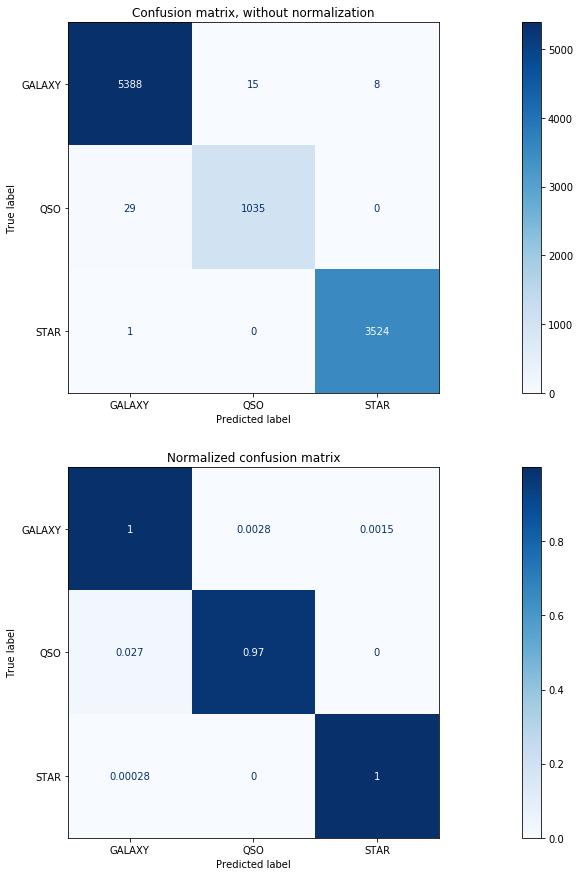

In [17]:
# Prediction of the model from test set
y_pred = rd_forest.predict(X_test)

print(confusion_matrix(y_test, y_pred, labels=["STAR", "GALAXY", "QSO"], normalize = 'true'))
print(classification_report(y_test, y_pred, labels=["STAR", "GALAXY", "QSO"]))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax =plt.subplots(2,1,figsize=(30,15))

for i in range(2):
    plot_confusion_matrix(rd_forest,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=titles_options[i][1], ax = ax[i])
    ax[i].set_title(titles_options[i][0])
    

    print(titles_options[i])

plt.show()

In [10]:
rd_forest.feature_importances_

array([0.13519856, 0.04079417, 0.19986431, 0.09951262, 0.52463034])

# Using rebalanced train set with Random Forest

In [20]:
sky_tr_st = sky_train[sky_train['class'] == 'STAR']
sky_tr_gl = sky_train[sky_train['class'] == 'GALAXY']
sky_tr_qso = sky_train[sky_train['class'] == 'QSO']

In [21]:
# Resample data to know if model performs better on balanced data classes
from sklearn.utils import resample

sky_tr_st = resample(sky_tr_st, n_samples = sky_tr_qso.shape[0], random_state = 123)
sky_tr_gl = resample(sky_tr_gl, n_samples = sky_tr_qso.shape[0], random_state = 123)

sky_balanced = pd.concat([sky_tr_st, sky_tr_gl, sky_tr_qso], axis = 0)
sky_balanced['class'].value_counts()

GALAXY    52155
QSO       52155
STAR      52155
Name: class, dtype: int64

In [22]:
# Final preprocessing of the Balanced Train Set
X_bal = preprocessing.fit_transform(sky_balanced.drop('class', axis=1))
y_bal = sky_balanced['class']

In [23]:
# Training of the balanced set
start = time.time()
rd_forest_bal = RandomForestClassifier(n_estimators = 100, max_depth = 25).fit(X_bal,y_bal)
elapsed_time = time.time()-start
print("Finished training in: {} seconds".format(str(int(elapsed_time))))

Finished training in: 81 seconds


[[0.97361702 0.0235461  0.00283688]
 [0.00813158 0.75549806 0.23637036]
 [0.         0.01221805 0.98778195]]
              precision    recall  f1-score   support

        STAR       0.99      0.97      0.98      3525
      GALAXY       0.98      0.76      0.85      5411
         QSO       0.45      0.99      0.62      1064

    accuracy                           0.86     10000
   macro avg       0.80      0.91      0.82     10000
weighted avg       0.92      0.86      0.87     10000

('Confusion matrix, without normalization', None)
('Normalized confusion matrix', 'true')


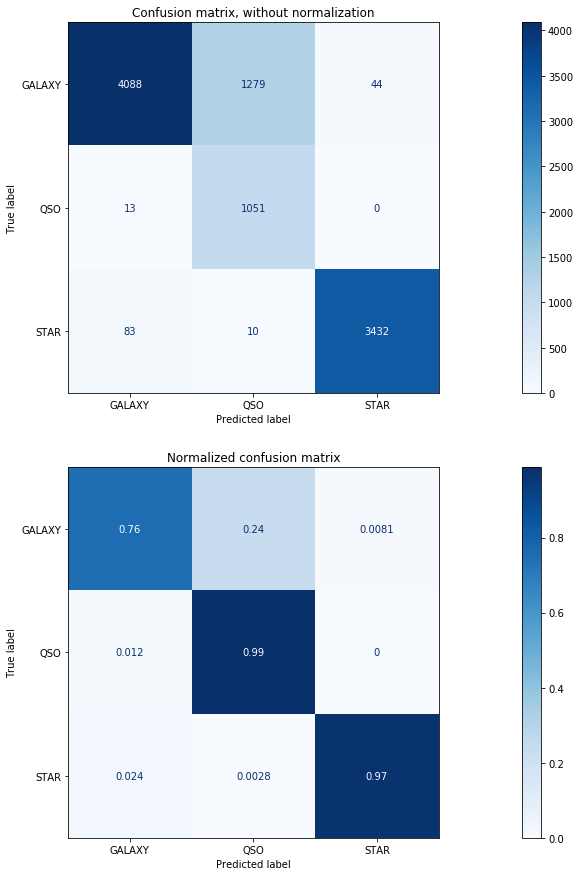

In [24]:
# Test Set prediction of the balanced model

y_pred_bal = rd_forest_bal.predict(X_test)

print(confusion_matrix(y_test, y_pred_bal, labels=["STAR", "GALAXY", "QSO"], normalize = 'true'))
print(classification_report(y_test, y_pred_bal, labels=["STAR", "GALAXY", "QSO"]))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax =plt.subplots(2,1,figsize=(30,15))

for i in range(2):
    plot_confusion_matrix(rd_forest_bal,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=titles_options[i][1], ax = ax[i])
    ax[i].set_title(titles_options[i][0])
    

    print(titles_options[i])

plt.show()

It is actually worse than training on the unbalanced dataset

# Unsupervised outlier detection

## Preprocessing all the dataset (no train/test)

In [11]:
sky_all = pd.concat([sky_train, sky_test], axis = 0)
sky_all.head()
sky_all.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'class'], dtype='object')

In [13]:
# custom function to pipeline Transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# construction of preprocessing pipeline

new_transform = ColumnTransformer([('ci_redshift', ci_redshift, ['u', 'g', 'r', 'i', 'z', 'redshift']), 
                                   ('one_hot', OneHotEncoder(), ['class'])])
new_pipeline = Pipeline([('new_transform', new_transform), ('scaling', StandardScaler())])

sky_all_prep = new_pipeline.fit_transform(sky_all)

## Creating the model

In [34]:
from sklearn.ensemble import IsolationForest
isolation = IsolationForest(contamination = 0.0001).fit(sky_all_prep)

In [35]:
pred = isolation.predict(sky_all_prep)

In [36]:
sky_all_pred = pd.concat([sky_all.reset_index(drop=True), pd.Series(pred, name='anomaly')], axis = 1)
sky_all_pred[sky_all_pred['anomaly'] == -1].shape

(50, 8)

In [37]:
sky_all_pred.loc[sky_all_pred['anomaly']==-1,'class'].value_counts()

GALAXY    26
QSO       20
STAR       4
Name: class, dtype: int64